# Mean Variance Frontier with Short Sales Constraints

This code below calculates mean variances frontiers *(a)* when there are no restrictions on the portfolio weights and *(b)* when we impose the restriction that no weights can be negative.

The latter case requires a numerical minimization routine (the code uses quadprog), which comes from the packages MathProgBase and Ipopt.

# Load Packages

In [1]:
using Dates, MathProgBase, Ipopt        

include("jlFiles/printmat.jl")    

printlnPs (generic function with 2 methods)

In [2]:
using Plots
backend = "gr"              #"gr" (default), "pyplot" 

if backend == "pyplot"
    pyplot(size=(600,400))
else    
    gr(size=(480,320))
    default(fmt = :svg)
end

# Traditional MV Calculations 

(no constraints)

In [3]:
μ = [11.5; 9.5; 6]/100      #expected returns
Σ  = [166  34  58;          #covariance matrix
       34  64   4;
       58   4 100]/100^2                  
Rf = 0.03

println("μ, Σ and Rf: ")
printmat(μ)
printmat(Σ)
printlnPs(Rf)

μ, Σ and Rf: 
     0.115
     0.095
     0.060

     0.017     0.003     0.006
     0.003     0.006     0.000
     0.006     0.000     0.010

     0.030


## From Chapter on MV Analysis

The file included below contains the functions `MVCalc()`, `MVCalcRf()` and `MVTangencyP()` from the chapter on MV analysis.

In [4]:
include("jlFiles/MvCalculations.jl")

MVTangencyP

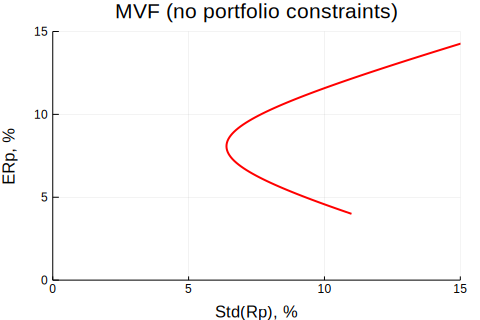

In [5]:
mustar = range(0.04,stop=0.15,length=101)      
L      = length(mustar)
StdRp  = fill(NaN,L)
for i = 1:L
    StdRp[i] = MVCalc(mustar[i],μ,Σ)[1]
end    

p1 = plot(StdRp*100,mustar*100,color=:red,linewidth=2,legend=false)
plot!(xlim=(0,15),ylim=(0,15))
title!("MVF (no portfolio constraints)")
xlabel!("Std(Rp), %")
ylabel!("ERp, %")

# MV Frontier when Short Sales are Not Allowed

The code below solves (numerically) the following minimization problem 

$\min \text{Var}(R_p) \: \text{ s.t. } \: \text{E}R_p = \mu^*$,
 
and where we require $w_i\ge 0$.
 
The code below calls on
```
quadprog(zeros(n),Sigma,A,'=',b,zeros(n),ones(n),IpoptSolver(print_level=1))
```

This means that we minimize
$0'w + w' \Sigma w/2$ subject to the constraints $A w = b$ and $0 \leq w \leq 1$. The equality constraints ($A w = b$) are used to impose $1'w=1$ and $\mu'w = \mu^*$ (se the code below).
    
The ```quadprog()``` function is tailor made for linear-quadratic optimization problems with constraints. More general optimization functions would also work, but are likely to be slower.

In [6]:
function MeanVarNoSSPs(mu,Sigma,mustar)   #MV with no short-sales, numerical minimization
    (w_p,StdRp) = (NaN,NaN)               #default result (if no feasible solution)        
    n = length(mu)
    if minimum(mu) <= mustar <= maximum(mu)  #try only if feasible
        A   = [ones(1,n);mu']                #1'w=1, mu'w = mustar
        b   = [1;mustar]
        Sol = quadprog(zeros(n),Sigma,A,'=',b,zeros(n),ones(n),IpoptSolver(print_level=1))
        if Sol.status == :Optimal
            w_p = Sol.sol
            StdRp = sqrt(w_p'Sigma*w_p)
        end    
    end    
    return StdRp,w_p
end

MeanVarNoSSPs (generic function with 1 method)

In [7]:
Std_no_ss = fill(NaN,length(mustar))
for i = 1:length(mustar)
    Std_no_ss[i] = MeanVarNoSSPs(μ,Σ,mustar[i])[1]     #[1] to get first output
end


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



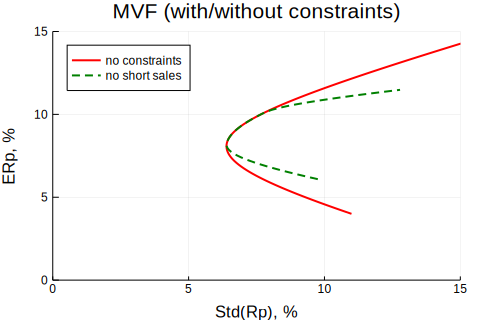

In [8]:
p1 = plot(StdRp*100,mustar*100,color=:red,linewidth=2,label="no constraints")
plot!(Std_no_ss*100,mustar*100,color=:green,line=(:dash,2),label="no short sales")
plot!(xlim=(0,15),ylim=(0,15),legend=:topleft)
title!("MVF (with/without constraints)")
xlabel!("Std(Rp), %")
ylabel!("ERp, %")